In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display

from dataset import Dataset
from gen_video import gen_video

Camera position mean & std:
[ -1.9723758  -11.407406     0.36299774] [10.950828   5.4356313 11.073948 ]


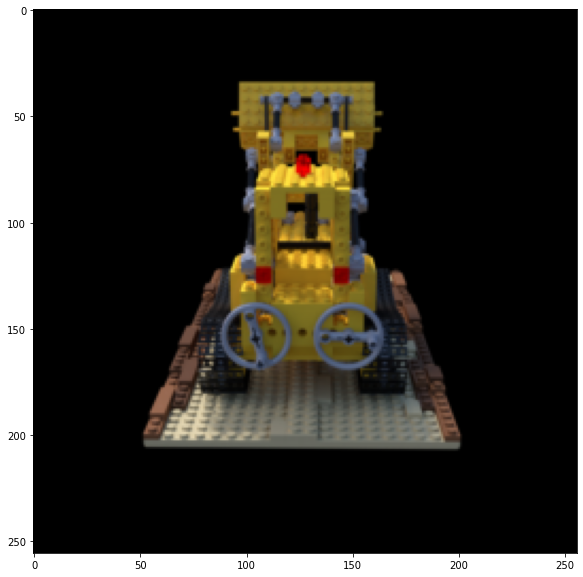

In [2]:
dataset = Dataset('../public/data/lego', 'blender')
H, W = dataset.H, dataset.W
plt.figure(figsize=(10, 10))
plt.imshow(dataset.images[0].permute(1,2,0))

In [3]:
i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                   np.arange(H, dtype=np.float32), indexing='xy')
grid = np.stack([(i+1/W)/(W+1), 1-(j+1/H)/(H+1)], 0)
grid = torch.tensor(grid, device='cuda')

In [4]:
(grid.shape, grid.max())

(torch.Size([2, 256, 256]), tensor(1.0000, device='cuda:0'))

In [212]:
# https://github.com/skeeto/hash-prospector
#lowbias32
def hash(x):
    x = x.clone()
    # no uint64 in torch
    x += torch.iinfo(torch.int64).max // 2
    
    x ^= x >> 16
    x *= 0x7feb352d
    x ^= x >> 15
    x *= 0x846ca68b
    x ^= x >> 16
    return x

def ndhash(x):
    # hash over tensor of n dimensional points, where n is the first dimension
    # returns int tensor with first dimension removed
    y = hash(x[0])
    for i in range(x.shape[0] - 1):
        y = hash(y ^ x[i + 1])
    return y

In [182]:
# https://lemire.me/blog/2018/08/15/fast-strongly-universal-64-bit-hashing-everywhere/
# todo: string hash method instead of ndhash
_="""
[a, b, c] = torch.randint(torch.iinfo(torch.int64).max, (3,))
def hash32(x):
    low = x.type(torch.int32)
    high = (x >> 32).type(torch.int32)
    return ((a * low + b * high + c) >> 32).type(torch.int32)

def ndhash(x):
    y = hash32(x[0])
    for i in range(x.shape[0] - 1):
        y = hash32(y ^ x[i + 1])
    return y
"""

In [183]:
hash(torch.tensor([-2,-1,-0,0,1,2])) % 20000

tensor([18465,  7424, 13280, 13280,  6432, 18816])

In [259]:
def multiscale_hash(x, table, n_levels):
    # multiscale hash over tensor of n dimensional points, where n is the first dimension
    # returns int tensor where first dimension is removed, and two are added to the end
    # first is over levels, 2nd is over features
    y = torch.zeros(*x.shape[1:], 3, device='cuda')
    x = torch.cat([x, torch.ones_like(x[:1])], axis=0)
    x = (x * 2**n_levels).int()
    if True:
        xl = torch.tile(x[..., None], (1,) * (x.ndim - 1) + (n_levels,))
        xl = torch.div(xl, (2**(torch.arange(n_levels, device='cuda') + 1)), rounding_mode='floor')
        y = table[ndhash(xl).long() % table.shape[0]]
        return y
        y = torch.sum(y, -2)
    else:
        for i in range(n_levels):
            y += table[ndhash(x).long() % table.shape[0]]
            x = torch.div(x, 2, rounding_mode='floor')
    return y / n_levels

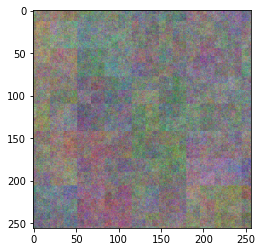

In [275]:
class HashModel(nn.Module):
    def __init__(self, table_size=int(1e6), table_channels=3,
                 n_levels=12, n_scene_points=1):
        super().__init__()
        self.table = nn.Parameter(torch.rand(table_size, table_channels))
        self.n_levels = n_levels
        
        self.layer1 = nn.Linear(6 + table_channels * n_levels, 64)
        self.layer2 = nn.Linear(64, 3)
        
        if n_scene_points == 1:
            self.scene_points = torch.zeros(1, 3, device='cuda')
        else:
            # randomly generate scene points
            ray_sel = np.random.choice(dataset.rays.shape[0], n_scene_points)
            depth_mins = dataset.bds[ray_sel // (H * W), 0]
            depth_maxs = dataset.bds[ray_sel // (H * W), 1]
            r = np.random.rand(n_scene_points).astype(np.float32)
            dists = depth_mins + r * (depth_maxs - depth_mins)
            dists = torch.tensor(dists[:, None], device='cuda')
            self.scene_points = dataset.rays[ray_sel, :3] + dataset.rays[ray_sel, 3:] * dists
    
    def forward(self, rays):
        # localize ray origins
        ray_origins = rays[:, :3].repeat_interleave(self.scene_points.shape[0], dim=0)
        dirs_repeat = rays[:, 3:].repeat_interleave(self.scene_points.shape[0], dim=0)
        scene_points = self.scene_points.repeat(rays.shape[0], 1)
        ro_to_points = scene_points - ray_origins
        t = (ro_to_points * dirs_repeat).sum(-1, keepdims=True)
        local_ro = ray_origins + dirs_repeat * t
        local_ro = local_ro.reshape(rays.shape[0], -1)
        
        #local_ro = local_ro * 0.5
        local_rays = torch.cat([local_ro, rays[:, 3:]], axis=-1)
        
        feats = multiscale_hash(local_rays.permute(1, 0), self.table, self.n_levels)
        feats = feats.reshape(feats.shape[0], -1)
        feats = torch.cat([local_rays, feats], axis=-1)
        h = self.layer1(feats).relu()
        y = self.layer2(h)
        return y

model = HashModel()
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
    lambda epoch: max(0.8 ** epoch, 0.1))
losses = []

y = multiscale_hash(grid - 0.2, model.table, model.n_levels)
y = torch.sum(y, -2) / model.n_levels
plt.imshow(y.detach().clip(0,1).cpu())

2000/2000


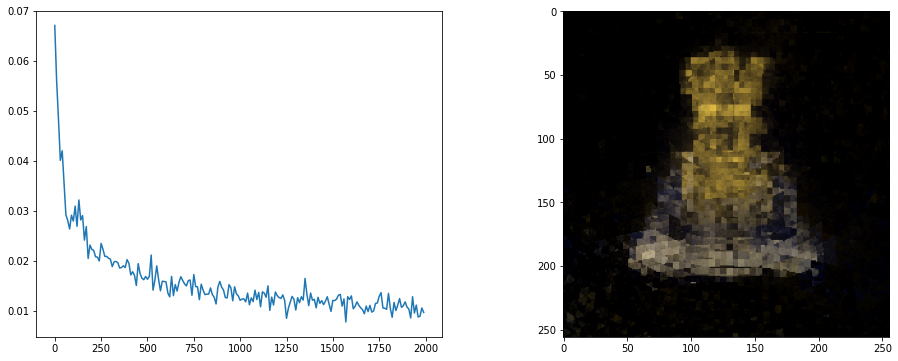

loss: 0.009615018032491207


In [276]:
n_iter = int(2e3)
batch_size = 512

for i in range(n_iter):
    sel = np.random.choice(dataset.rays.shape[0], batch_size)
    pred = model(dataset.rays[sel])
    loss = loss_fn(pred, dataset.colors[sel])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 10 == 0:
        losses.append(loss.item())
    if (i + 1) % 200 == 0:
        display.clear_output(wait=True)
        print(f'{i+1}/{n_iter}')
        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(np.arange(len(losses)) * 10, losses)
        plt.subplot(122)
        with torch.no_grad():
            x = dataset.rays[:H*W]
            plt.imshow(model(x).detach().clip(0,1).reshape(H, W, 3).cpu())
        plt.show()
        print(f'loss: {losses[-1]}')
    if (i + 1) % 400 == 0:
        scheduler.step()
        pass

In [277]:
gen_video(dataset, model, 'videos/out.mp4')
display.clear_output()
display.display(display.HTML('<video src="videos/out.mp4" controls=true autoplay=true loop=true />'))